# Constrained transcripts
This script summarises transcript level constraints against nonsense variants in the UKB exomes.

## Preliminaries
Import modules, set plotting aesthetics, and download necessary data

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm

sns.set_context("talk")

In [2]:
%%bash

dx download -f data/supplementary_dataset_11_full_constraint_metrics.tsv -o ../data/

## Full transcripts
Assess constraint against nonsense variants in the full length of the transcript

In [24]:
# Read the constraint data to memory
df = pd.read_csv("../outputs/expected_variants_stats_no_cpg.tsv", sep="\t")

# Reformat the dataframe
df = df[["enst","csq","n_pos","prop_exp","n_exp","prop_obs","n_obs","oe","oe_diff","z","p"]]
df = df.set_index(["enst","csq"]).unstack("csq")
df.columns = df.columns.swaplevel(0,1)
df.sort_index(axis=1, level=0, inplace=True)

df.shape

(19623, 27)

In [25]:
# Get gnomAD pLI and LOEUF constraint data
pli = pd.read_csv("../data/supplementary_dataset_11_full_constraint_metrics.tsv", sep="\t")
pli = pli.set_index("transcript")

In [26]:
# Merge UKB and gnomAD constraint data
df = df.join(pli[["pLI", "oe_lof_upper"]], how="left")

/tmp/ipykernel_207/2622032986.py:2: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left, 1 on the right)
  df = df.join(pli[["pLI", "oe_lof_upper"]], how="left")


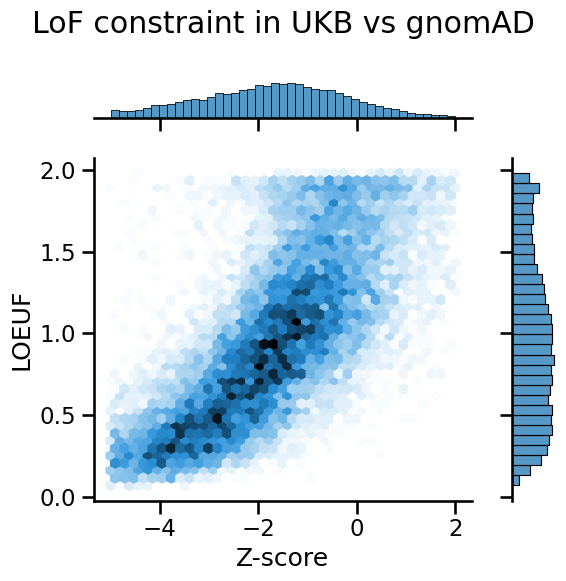

In [32]:
# Plot the relationship between the UKB nonsense Z-score and the gnomAD LOEUF score
g = sns.jointplot(data=df[df["nonsense", "z"].between(-5,2)],
            x=("nonsense","z"),
            y="oe_lof_upper",
            kind="hex",
                 )
g.set_axis_labels(xlabel="Z-score",
                  ylabel="LOEUF",
                 )
g.fig.suptitle("LoF constraint in UKB vs gnomAD")
g.fig.tight_layout()

In [33]:
# Exclude transcripts with fewer synonymous variants than expected
# These likely represent poorly covered transcripts

m1 = df["synonymous","n_obs"] > 10
m2 = df["synonymous","z"] >= -1
m3 = df["missense","n_obs"] > 10

df = df[m1 & m2 & m3]
df.shape

(14473, 29)

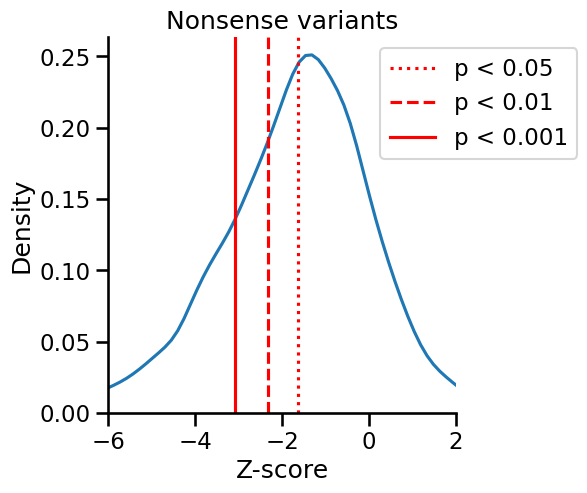

In [38]:
# Plot the distribution of nonsense Z-scores
g = sns.displot(kind="kde",
                data=df,
                x=("nonsense","z")
               )
g.set(xlim=(-6,2),
      title="Nonsense variants",
      xlabel="Z-score",
     )

# Add vertical lines for significance thresholds
p_values = 0.05, 0.01, 0.001
linestyles = ":", "--", "-"

for p, l in zip(p_values, linestyles):
    plt.axvline(x = norm.ppf(p), # Critical value for one-tail Z-test
                color="r", 
                linestyle=l,
                label = f"p < {p}"
               )

# Adjust the legend position
plt.legend(bbox_to_anchor = (0.75, 1), loc = 'upper left')

In [47]:
# Summarise the number of transcripts meeting p-value thresholds
def get_p_stats_transcript(df):
    p_vals = df[[("nonsense", "n_obs"), ("nonsense","p")]].copy()
    p_vals.columns = ["n_obs","p"]
    p_vals["p_value_bin"] = pd.cut(p_vals["p"], bins=[0,0.001,0.01,0.05,1])
    p_stats = p_vals.groupby("p_value_bin").agg({"p":"count"})
    p_stats["none_observed"] = p_vals.groupby("p_value_bin")["n_obs"].apply(lambda x: (x==0).sum())
    p_stats.columns = ["count","none_observed"]
    return p_stats

get_p_stats_transcript(df)

,count,none_observed
p_value_bin,,
"(0.0, 0.001]",2998,249
"(0.001, 0.01]",1789,126
"(0.01, 0.05]",2165,141
"(0.05, 1.0]",7521,50


## NMD
Find constraint against nonsense variants in NMD-escaping and NMD-triggering regions

In [50]:
# Read NMD constraint data to memory
nmd = pd.read_csv("../outputs/expected_variants_stats_no_cpg_nmd.tsv", sep="\t")

# Reformat data
nmd = nmd.set_index(["enst","csq","nmd"]).unstack(["csq", "nmd"])
nmd.columns = nmd.columns.swaplevel(0,2).swaplevel(0,1)
nmd.sort_index(axis=1, level=[0,1], inplace=True)

### Plot regional nonsense constraint Z-scores

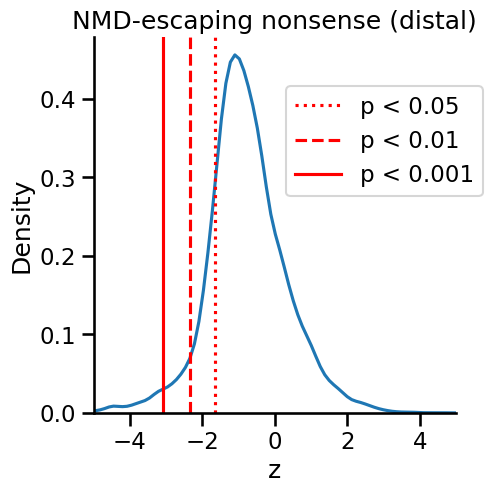

In [12]:
g = sns.displot(kind="kde",
            data=nmd[("nonsense", "distal_nmd")],
            x = "z"
           )
g.set(title="NMD-escaping nonsense (distal)",
      xlim=(-5,5))

plt.axvline(x=-1.645, color="r", linestyle=":", label = "p < 0.05")
plt.axvline(x=-2.326, color="r", linestyle="--", label = "p < 0.01")
plt.axvline(x=-3.09, color="r", linestyle="-", label = "p < 0.001")

plt.legend(bbox_to_anchor = (0.5, 0.9), loc = 'upper left')

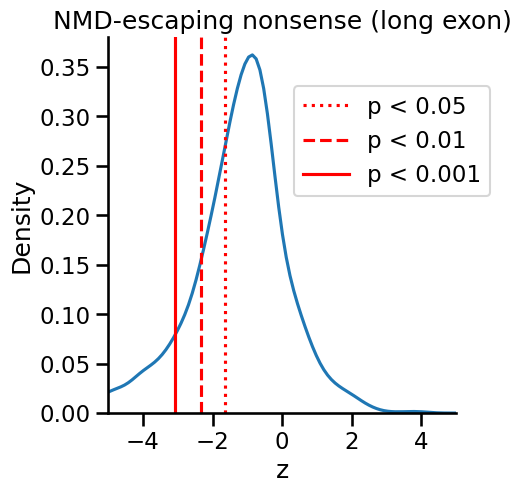

In [13]:
g = sns.displot(kind="kde",
            data=nmd[("nonsense", "long_exon")],
            x = "z"
           )
g.set(title="NMD-escaping nonsense (long exon)",
      xlim=(-5,5))

plt.axvline(x=-1.645, color="r", linestyle=":", label = "p < 0.05")
plt.axvline(x=-2.326, color="r", linestyle="--", label = "p < 0.01")
plt.axvline(x=-3.09, color="r", linestyle="-", label = "p < 0.001")

plt.legend(bbox_to_anchor = (0.5, 0.9), loc = 'upper left')

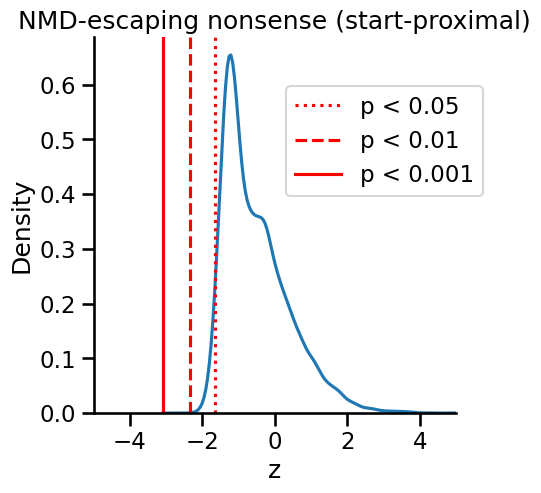

In [14]:
g = sns.displot(kind="kde",
            data=nmd[("nonsense", "start_proximal")],
            x = "z"
           )
g.set(title="NMD-escaping nonsense (start-proximal)",
      xlim=(-5,5))

plt.axvline(x=-1.645, color="r", linestyle=":", label = "p < 0.05")
plt.axvline(x=-2.326, color="r", linestyle="--", label = "p < 0.01")
plt.axvline(x=-3.09, color="r", linestyle="-", label = "p < 0.001")

plt.legend(bbox_to_anchor = (0.5, 0.9), loc = 'upper left')

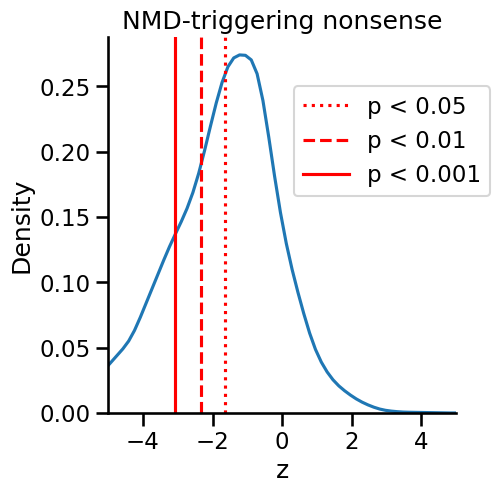

In [15]:
g = sns.displot(kind="kde",
            data=nmd[("nonsense", "nmd_target")],
            x = "z"
           )
g.set(title="NMD-triggering nonsense",
      xlim=(-5,5))

plt.axvline(x=-1.645, color="r", linestyle=":", label = "p < 0.05")
plt.axvline(x=-2.326, color="r", linestyle="--", label = "p < 0.01")
plt.axvline(x=-3.09, color="r", linestyle="-", label = "p < 0.001")

plt.legend(bbox_to_anchor = (0.5, 0.9), loc = 'upper left')

### How can we fairly exclude low-coverage transcripts?
Using a synonymous Z-score cutoff

### Distal NMD-escape

In [16]:
region = "distal_nmd"
df = nmd.copy()

# Exclude transcripts with low synonymous Z-scores
df = df[df[("synonymous", region, "z")] > -1]
print(f"Remaining transcripts: {len(df)}")

# Summarise the number of transcripts meeting p-value thresholds
def get_p_stats(df, region):
    p_vals = df[[("nonsense", region,"n_obs"), ("nonsense", region,"p")]].copy()
    p_vals.columns = ["n_obs","p"]
    p_vals["p_bin"] = pd.cut(p_vals["p"], bins=[0,0.001,0.01,0.05,1])
    p_stats = p_vals.groupby("p_bin").agg({"p":"count"})
    p_stats["none_observed"] = p_vals.groupby("p_bin")["n_obs"].apply(lambda x: (x==0).sum())
    return p_stats

p_stats = get_p_stats(df, region)
p_stats

Remaining transcripts: 15096


,p,none_observed
p_bin,,
"(0.0, 0.001]",290,59
"(0.001, 0.01]",414,82
"(0.01, 0.05]",1439,750
"(0.05, 1.0]",12837,3489


### Long exon NMD-escape

In [17]:
region = "long_exon"
df = nmd.copy()

# Exclude transcripts with low synonymous Z-scores
df = df[df[("synonymous", region, "z")] > -1]
print(f"Remaining transcripts: {len(df)}")

# Summarise the number of transcripts meeting p-value thresholds
p_stats = get_p_stats(df, region)
p_stats

Remaining transcripts: 2903


,p,none_observed
p_bin,,
"(0.0, 0.001]",266,56
"(0.001, 0.01]",221,71
"(0.01, 0.05]",397,156
"(0.05, 1.0]",1949,644


### NMD-targeted regions

In [18]:
region = "nmd_target"
df = nmd.copy()

# Exclude transcripts with low synonymous Z-scores
df = df[df[("synonymous", region, "z")] > -1]
print(f"Remaining transcripts: {len(df)}")

# Summarise the number of transcripts meeting p-value thresholds
p_stats = get_p_stats(df, region)
p_stats

Remaining transcripts: 12087


,p,none_observed
p_bin,,
"(0.0, 0.001]",1976,275
"(0.001, 0.01]",1309,196
"(0.01, 0.05]",1813,314
"(0.05, 1.0]",6926,962


In [19]:
def region_constraint(df, region):
    m1 = df["synonymous",region,"z"]>-1
    m2 = df["nonsense",region,"p"]<0.001
    m3 = df["nonsense",region,"p"]<0.01
    m4 = df["nonsense",region,"n_obs"]==0
    m5 = df["nonsense","nmd_target", "p"] > 0.05
    m6 = df["nonsense","nmd_target", "p"].isna()

    df = df[(m1 & (m2 | (m3 & m4))) & (m5 | m6)]
    df = df.loc[:,(["nonsense"], [region, "nmd_target"], ["n_pos","n_exp","n_obs","oe","z","p"])]
    df = df.sort_values(("nonsense", "nmd_target", "n_exp"), ascending=False)

    return df

distal = region_constraint(nmd, "distal_nmd")
long_exon = region_constraint(nmd, "long_exon")
start_proximal = region_constraint(nmd, "start_proximal")

In [20]:
print(f"{len(distal), len(long_exon)}")

(215, 25)


In [21]:
distal.head(20)

csq               nonsense                                                  \
nmd             distal_nmd                                                   
                     n_pos   n_exp n_obs        oe         z             p   
enst                                                                         
ENST00000367739       94.0    6.31   0.0  0.000000 -2.601852  4.636096e-03   
ENST00000378116      226.0   21.21   3.0  0.141443 -4.153043  1.640412e-05   
ENST00000322054       60.0    6.14   0.0  0.000000 -2.614885  4.462873e-03   
ENST00000326441      555.0   45.06   8.0  0.177541 -5.759628  4.214984e-09   
ENST00000333244     1609.0  135.33  96.0  0.709377 -3.532602  2.057455e-04   
ENST00000303924      153.0   15.26   2.0  0.131062 -3.577680  1.733291e-04   
ENST00000339488      198.0   17.45   4.0  0.229226 -3.372580  3.723379e-04   
ENST00000272164       59.0    5.90   0.0  0.000000 -2.561446  5.211879e-03   
ENST00000569188      123.0   14.31   2.0  0.139762 -3.461222  2.688642e-04   
ENST00000366795      169.0   18.55   5.0  0.269542 -3.334714  4.269365e-04   
ENST00000523207      246.0   22.48   6.0  0.266904 -3.646579  1.328774e-04   
ENST00000398795       58.0    5.31   0.0  0.000000 -2.417319  7.817644e-03   
ENST00000372488       70.0    6.52   0.0  0.000000 -2.680476  3.675878e-03   
ENST00000345093       46.0    5.40   0.0  0.000000 -2.474010  6.680293e-03   
ENST00000237455      269.0   24.59   4.0  0.162668 -4.356040  6.621833e-06   
ENST00000615612       48.0    5.18   0.0  0.000000 -2.409846  7.979634e-03   
ENST00000275364       55.0    5.51   0.0  0.000000 -2.475072  6.660460e-03   
ENST00000618550       34.0    4.97   0.0  0.000000 -2.411769  7.937671e-03   
ENST00000539517      112.0    9.35   0.0  0.000000 -3.194794  6.996542e-04   
ENST00000609713       50.0    4.93   0.0  0.000000 -2.339240  9.661502e-03   

csq                                                                   
nmd             nmd_target                                            
                     n_pos n_exp n_obs        oe         z         p  
enst                                                                  
ENST00000367739      107.0  9.46   7.0  0.739958 -0.836970  0.201305  
ENST00000378116       82.0  8.66   5.0  0.577367 -1.314014  0.094421  
ENST00000322054       77.0  7.64   5.0  0.654450 -1.007578  0.156829  
ENST00000326441       79.0  7.44   4.0  0.537634 -1.325036  0.092580  
ENST00000333244       67.0  6.38   4.0  0.626959 -0.989847  0.161124  
ENST00000303924       72.0  5.95   3.0  0.504202 -1.263753  0.103159  
ENST00000339488       60.0  5.84   3.0  0.513699 -1.235339  0.108352  
ENST00000272164       54.0  5.84   3.0  0.513699 -1.243746  0.106797  
ENST00000569188       48.0  5.70   5.0  0.877193 -0.311481  0.377717  
ENST00000366795       44.0  5.53   5.0  0.904159 -0.241289  0.404666  
ENST00000523207       56.0  5.17   2.0  0.386847 -1.462164  0.071848  
ENST00000398795       53.0  4.64   2.0  0.431034 -1.282976  0.099750  
ENST00000372488       37.0  4.20   3.0  0.714286 -0.624115  0.266276  
ENST00000345093       42.0  3.96   1.0  0.252525 -1.563141  0.059010  
ENST00000237455       46.0  3.67   2.0  0.544959 -0.909986  0.181415  
ENST00000615612       35.0  3.64   1.0  0.274725 -1.460519  0.072074  
ENST00000275364       33.0  3.57   1.0  0.280112 -1.440513  0.074861  
ENST00000618550       38.0  3.47   1.0  0.288184 -1.391597  0.082022  
ENST00000539517       37.0  3.45   1.0  0.289855 -1.384291  0.083135  
ENST00000609713       36.0  3.37   1.0  0.296736 -1.355750  0.087589